In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "1" # Case 1 is for anomalous density diffusion only.
filepath = "circle2/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle2_lowestres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 46MB
Dimensions:             (x: 68, y: 1, z: 68, t: 201)
Coordinates:
    dx                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dy                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    dz                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 544B 0 1 2 3 4 5 6 7 ... 61 62 63 64 65 66 67
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 544B 0.007353 0.02206 ... 0.9779 0.9926
Data variables: (12/52)
    Bxy                 (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G1                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 68), meta=np.ndarray>
    G2                  (x, y, z) float64 37kB dask.array<chunksize=(68, 1, 

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

src = ds["SNh+"][:,2:-2,:]

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

Nh+ data passed has 3 dimensions - will use animatplot.blocks.Pcolormesh()


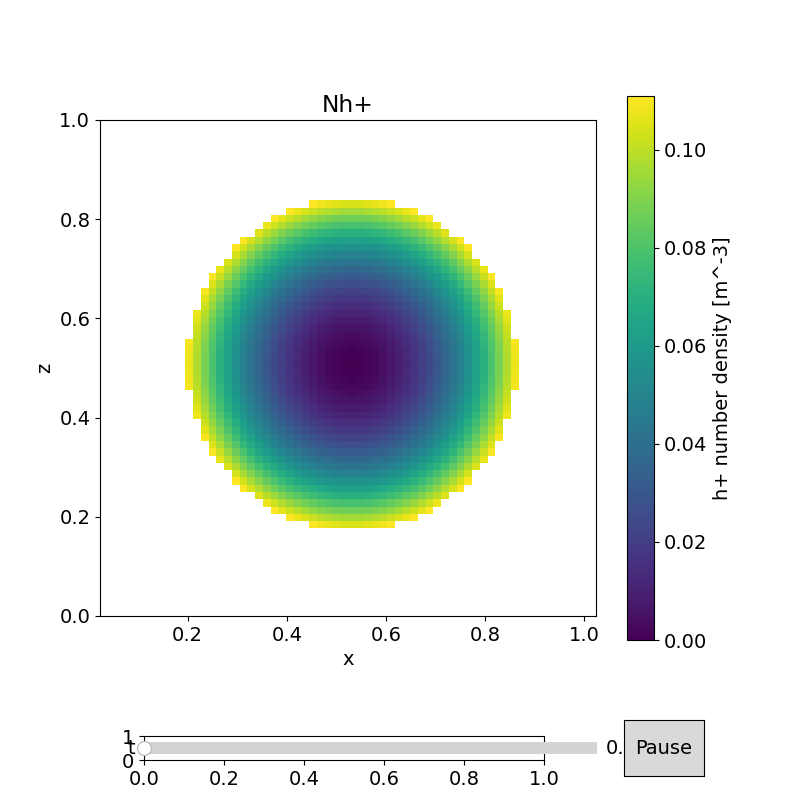

In [9]:
import xarray as xr
mask_bool = mask.fillna(False).astype(bool)   # make it boolean, handle NaNs
src2 = src.where(~mask_bool)                  # keep where mask is False
#src.bout.animate2D(aspect='equal')
dens.where(mask).bout.animate2D(aspect='equal')

In [12]:
M0 = dens.where(mask)[0,:,:].sum().values
M1 = dens.where(mask)[1,:,:].sum().values
print(M0)
print(M1)
print("ΔM =", M1 - M0)
print("relative change =", (M1 - M0)/M0)
#assert np.isclose(M1, M0, rtol=1e-10, atol=1e-14)


84.83053261516002
84.65725121597154
ΔM = -0.1732813991884825
relative change = -0.0020426772512980246


In [ ]:
res_true = (D/(x_unit*x_unit*w_unit))*(beta0**2/(a/x_unit)**2)*dens_true.where(mask)[0,:,:]
res_sim = ds["SNh+"][0,2:-2,:].where(mask)

res = res_sim - res_true

print(np.shape(res))

res_L2 = np.sqrt(np.nansum((res**2)) * dx*dz)
print("||res||_L2 =", float(res_L2)) #, "   relative =", float(rel_res))

In [ ]:
print(dens0.values[0,len(x)//2, len(z)//2])
print(true0.values[0,len(x)//2, len(z)//2])
print(dens0.values[1,len(x)//2, len(z)//2])
print(true0.values[1,len(x)//2, len(z)//2])
print((dens0 - true0).values[1,len(x)//2,len(z)//2])

In [ ]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens_true.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])
print((dens - dens_true).values[1,len(x)//2,len(z)//2])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask):
    """
    Erode by 1 cell so a 2nd-order centered stencil fits entirely in the fluid.
    fluid_mask: (ny, nx) bool (True = fluid)
    returns    : (ny, nx) bool 'core' mask
    """
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    # require 4-neighbors to be fluid
    core[:-1,:]  &= f[1:,:]
    core[1:,:]   &= f[:-1,:]
    core[:,:-1]  &= f[:,1:]
    core[:,1:]   &= f[:,:-1]
    # strip outer ring so centered diffs are valid
    core[[0,-1],:] = False
    core[:,[0,-1]] = False
    return core

def h1_seminorm_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None):
    """
    u_h, u_mms : (nt, ny, nx)
    fluid_mask : (ny, nx) bool (True = fluid; False = solid/ghost)
    dx, dy     : scalars
    w_frac     : optional (ny, nx) fractional fluid areas ∈[0,1]
    returns    : (nt,) H1 seminorm (gradients only) over interior core
    """
    u_h   = np.asarray(u_h);   u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx), "u_h and u_mms shapes must match"

    # centered diffs
    ux_h   = (u_h[:, :, 2:] - u_h[:, :, :-2]) / (2.0*dx)   # (nt, ny,   nx-2)
    ux_mms = (u_mms[:, :, 2:] - u_mms[:, :, :-2]) / (2.0*dx)
    uy_h   = (u_h[:, 2:, :] - u_h[:, :-2, :]) / (2.0*dy)   # (nt, ny-2, nx)
    uy_mms = (u_mms[:, 2:, :] - u_mms[:, :-2, :]) / (2.0*dy)

    # align to common interior footprint: (nt, ny-2, nx-2)
    ex = (ux_h - ux_mms)[:, 1:-1, :]     # drop first/last y
    ey = (uy_h - uy_mms)[:, :, 1:-1]     # drop first/last x
    grad_err_sq = ex**2 + ey**2          # (nt, ny-2, nx-2) = (nt, 254, 258)

    # core mask (same (ny,nx) grid as u), then crop to (ny-2,nx-2)
    core = build_core_mask(fluid_mask)           # (ny, nx)
    core_int = core[1:-1, 1:-1]                  # (ny-2, nx-2)

    # weights on (ny-2, nx-2)
    if w_frac is None:
        weights2d = core_int.astype(float)
    else:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx), "w_frac must be (ny, nx)"
        weights2d = core_int.astype(float) * wf[1:-1, 1:-1]

    # weighted integral over space (2-D weights broadcast over time)
    num = np.sum(grad_err_sq * weights2d, axis=(1, 2)) * dx * dy     # (nt,)
    den = np.sum(weights2d) * dx * dy + 1e-300                       # scalar

    return np.sqrt(num / den)


# Example:
# core_mask is 2D and constant in time
H1_series = h1_seminorm_time(dens, dens_true, mask, dx, dz)
H1_final  = H1_series[-1]

print(H1_series[10])

In [ ]:
import numpy as np

def build_core_mask(fluid_mask, radius=1):
    """Binary-erosion by `radius` cells so centered stencils stay inside the fluid."""
    f = np.asarray(fluid_mask, dtype=bool)
    core = f.copy()
    for _ in range(radius):
        core[:-1,:]  &= f[1:,:]
        core[1:,:]   &= f[:-1,:]
        core[:,:-1]  &= f[:,1:]
        core[:,1:]   &= f[:,:-1]
        core[[0,-1],:] = False
        core[:,[0,-1]] = False
        f = core
    return core

def l2_interior_gaugefree_time(u_h, u_mms, fluid_mask, dx, dy, w_frac=None, radius=1):
    """
    u_h, u_mms : (nt, ny, nx) fields at the same times
    fluid_mask : (ny, nx) bool (True = fluid, False = solid/ghost)
    dx, dy     : grid spacings (uniform). For nonuniform, fold areas into w_frac.
    w_frac     : optional (ny, nx) fractional fluid areas in [0,1]; defaults to 1 on core
    radius     : erosion in cells to define the *interior* core (e.g., 1–3)
    returns    : (nt,) L2 errors on the interior core after removing best-fit constant
    """
    u_h   = np.asarray(u_h);   u_mms = np.asarray(u_mms)
    nt, ny, nx = u_h.shape
    assert u_mms.shape == (nt, ny, nx), "u_h and u_mms must match shape"

    # Interior core (same grid as fields)
    core = build_core_mask(fluid_mask, radius=radius)   # (ny, nx)

    # Weights on the core
    if w_frac is None:
        weights2d = core.astype(float)                  # 1.0 on core, 0 elsewhere
    else:
        wf = np.asarray(w_frac, dtype=float)
        assert wf.shape == (ny, nx), "w_frac must be (ny, nx)"
        weights2d = core.astype(float) * wf             # fractional areas on core

    # Best-fit constant per time over *the same* interior weights
    # C*(t) = argmin || (u_h - u_mms - C) ||_L2(core)
    w_sum_cells = np.sum(weights2d)                     # dimensionless cell-weight sum
    if w_sum_cells == 0:
        raise ValueError("Interior core is empty; increase domain or reduce radius.")
    diff = u_h - u_mms                                  # (nt, ny, nx)
    C_t  = np.sum(diff * weights2d, axis=(1,2)) / (w_sum_cells + 1e-300)  # (nt,)

    # Gauge-free error on the core
    e = diff - C_t[:, None, None]                       # (nt, ny, nx)
    e2 = (e**2) * weights2d                             # (nt, ny, nx)

    # Proper L2 with area normalization
    area_core = w_sum_cells * dx * dy                   # total physical area of core
    num = np.sum(e2, axis=(1,2)) * dx * dy             # integrate over area
    return np.sqrt(num / (area_core + 1e-300))         # (nt,)

# core away from the IB; radius=1 for 2nd-order centered diffs,
# bump to 2–3 if you still see boundary contamination.
L2_series = l2_interior_gaugefree_time(dens, dens_true, mask, dx, dz,
                                       w_frac=None, radius=1)
L2_final = L2_series[-1]

print(L2_series[10])